In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import LeakyReLU

Using TensorFlow backend.


## 最小データ数の取得用関数
最もサンプル数の少ないデータの数を取得

In [0]:
def search_min_data_num(num_classes):
    # init
    dict_num = []

    for i in range(num_classes):
        file_name = "/content/drive/My Drive/Colab Notebooks/data2/" + TRAIN_DATA_FILES[i] + '.csv'
        data_set = pd.read_csv(file_name, header=None)
        
        num_data_set = len(data_set)
        dict_num.append(num_data_set)
        
        print(TRAIN_DATA_FILES[i], num_data_set, sep=': ')

    min_data_num = min(dict_num)
    print('\n')
    print("min_data_num:", min_data_num)
    
    return min_data_num

## Define

In [4]:
TRAIN_DATA_FILES = ['dead_end', 'left', 'right', 'straight', 'threeway_left', 'threeway_center', 'threeway_right']
#TRAIN_DATA_FILES = ['right', 'left', 'straight', 'dead_end']
# NUM_CLASSES = 6
NUM_CLASSES = len(TRAIN_DATA_FILES)
num_data_set = search_min_data_num(NUM_CLASSES)
REPLACE_NAN = 0.0

epochs = 120
batch_size = 100


dead_end: 3080
left: 3333
right: 1320
straight: 14943
threeway_left: 2926
threeway_center: 2827
threeway_right: 4301


min_data_num: 1320


## 学習データ数の調節用関数  
データ読み込み時、それぞれのラベルの学習データの内、最も数の少ないものに合わせる

In [0]:
def adjust_data_num(num_class):
    # header = 列名
    file_name = "/content/drive/My Drive/Colab Notebooks/data2/" + TRAIN_DATA_FILES[num_class] + '.csv'
    data_set = pd.read_csv(file_name, header=None)

    return data_set.sample(num_data_set)

## 学習データ読み込み用関数

In [0]:
def split_data():
    files = os.listdir('/content/drive/My Drive/Colab Notebooks/data2')
    X = []
    Y = []
    all_data_set = []
    labels = []


    for i in range(NUM_CLASSES):
        try:
            data_set = adjust_data_num(i)
            all_data_set.append(data_set)

            # one_hot_vectorを作りラベルとして追加
            tmp = np.zeros((num_data_set, NUM_CLASSES))
            tmp[:, i] = 1
            labels.append(tmp)
        except pd.io.common.EmptyDataError:
            print("ERROR: {} is empty".format(file_name))

    X = pd.concat(all_data_set)
    # replace Nan with 'REPLACE_NAN'
    X = X.fillna(REPLACE_NAN)
    Y = np.concatenate(labels, axis=0)

#    _, DIM_input_data = data_set.shape

    X_train, X_validation_and_test, Y_train, Y_validation_and_test = train_test_split(X, Y,train_size=0.6, test_size=0.4)
    X_validation, X_test, Y_validation, Y_test = train_test_split(X_validation_and_test, Y_validation_and_test, train_size=0.5, test_size=0.5)

    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

## ヒートマップ描画用関数

In [0]:
def print_cmx(y_true, predict, index=None):
    true_classes = np.argmax(y_true, 1)

    cmx_data = confusion_matrix(true_classes, predict)

    df_cmx = pd.DataFrame(cmx_data, index=index, columns=index)
    df_cmx = df_cmx.div(df_cmx.sum(axis=0, numeric_only=True), axis=0)

    plt.figure(figsize = (6,6))
    sns.heatmap(df_cmx, annot=True, fmt='.3f', square=True)
    plt.show()

## グラフプロット用関数

In [0]:
def plt_result(epochs, history):
    plt.plot(range(1, epochs+1), history.history['acc'], label="training")
    plt.plot(range(1, epochs+1), history.history['val_acc'], label="validation")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    predict_classes = model.predict_classes(X_test, batch_size=32)
    print_cmx(Y_test, predict_classes, TRAIN_DATA_FILES)

# 学習実行

###### データ読み込み

In [0]:
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = split_data()
_, DIM_input_data = X_train.shape

###### 学習

## ネットワーク設計
現在  
input(726) -  
<span>　</span>mid_lay1(dropout1) - mid_lay2(dropout2) -  
<span>　　</span>output(6)

In [0]:
# 726-1000-7 = 3層のネットワーク
DIM_HIDDEN1 = 1000

RATIO_DROP_OUT1 = 0.5

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

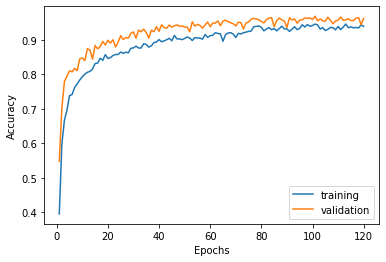

Test loss: 0.1738234069117736
Test accuracy: 0.9577922080502366


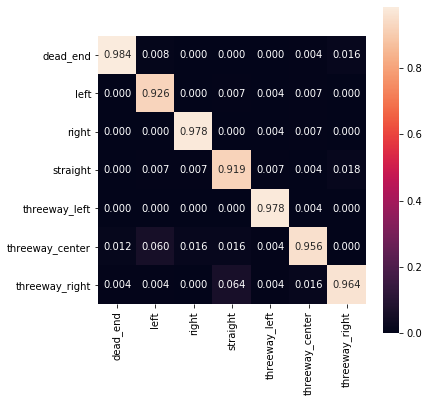

In [16]:
plt_result(epochs, history)

In [0]:
# 726-1000-7 = 3層のネットワーク
DIM_HIDDEN1 = 1000
RATIO_DROP_OUT1 = 0.5

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

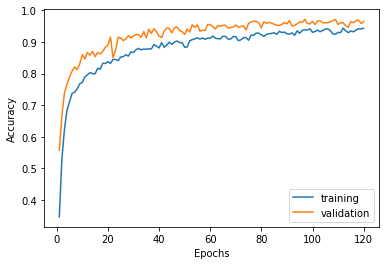

Test loss: 0.17400790347810433
Test accuracy: 0.9659090906510621


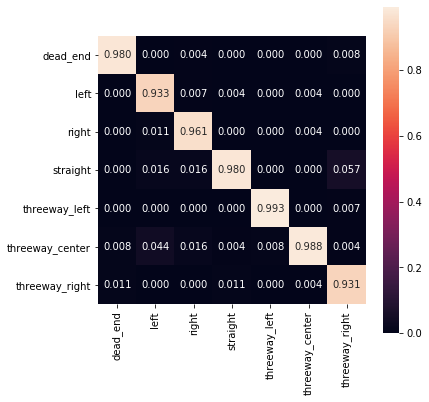

In [18]:
plt_result(epochs, history)

In [0]:
# 726-1000-7 = 3層のネットワーク
DIM_HIDDEN1 = 1000

RATIO_DROP_OUT1 = 0.5

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

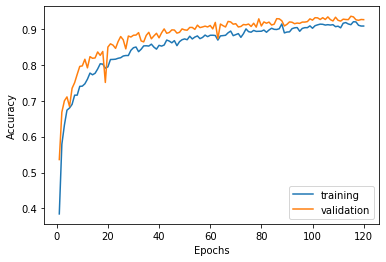

Test loss: 0.31439059478303194
Test accuracy: 0.9190777576853526


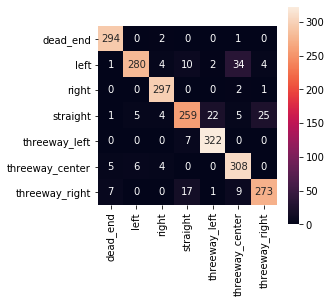

In [0]:
plt_result(epochs, history)

In [0]:
# 726-800-800-800-6 = 5層のネットワーク
DIM_HIDDEN1 = 3000
DIM_HIDDEN2 = 3000
DIM_HIDDEN3 = 3000

RATIO_DROP_OUT1 = 0.5
RATIO_DROP_OUT2 = 0.5
RATIO_DROP_OUT3 = 0.5

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(DIM_HIDDEN2, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT2))

model.add(Dense(DIM_HIDDEN3, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT3))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

In [0]:
plt_result(epochs, history)

In [0]:
# 726-800-800-800-6 = 5層のネットワーク
DIM_HIDDEN1 = 3000
DIM_HIDDEN2 = 3000
DIM_HIDDEN3 = 3000

RATIO_DROP_OUT1 = 0.5
RATIO_DROP_OUT2 = 0.5
RATIO_DROP_OUT3 = 0.5

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(DIM_HIDDEN2, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT2))

model.add(Dense(DIM_HIDDEN3, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT3))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

KeyboardInterrupt: ignored

In [0]:
plt_result(epochs, history)

In [0]:
# 726-800-800-800-6 = 5層のネットワーク
DIM_HIDDEN1 = 3000
DIM_HIDDEN2 = 3000
DIM_HIDDEN3 = 3000

RATIO_DROP_OUT1 = 0.5
RATIO_DROP_OUT2 = 0.5
RATIO_DROP_OUT3 = 0.5

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(DIM_HIDDEN2))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(RATIO_DROP_OUT2))

model.add(Dense(DIM_HIDDEN3))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(RATIO_DROP_OUT3))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

In [0]:
plt_result(epochs, history)

In [0]:
# 726-800-800-800-6 = 5層のネットワーク
DIM_HIDDEN1 = 3000
DIM_HIDDEN2 = 3000
DIM_HIDDEN3 = 3000

RATIO_DROP_OUT1 = 0.5
RATIO_DROP_OUT2 = 0.5
RATIO_DROP_OUT3 = 0.5

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(DIM_HIDDEN2))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(RATIO_DROP_OUT2))

model.add(Dense(DIM_HIDDEN3))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(RATIO_DROP_OUT3))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

In [0]:
plt_result(epochs, history)